# 🌸 Hybrid Quantum–Classical Neural Network on the Iris Dataset

This notebook implements a hybrid quantum-classical model that combines a quantum neural network (QNN) built using Qiskit with a classical neural layer in PyTorch.  
The goal is to classify samples from the Iris dataset - a small, well-known dataset in machine learning with four input features (sepal length, sepal width, petal length, petal width) and three target classes (Iris-setosa, Iris-versicolor, Iris-virginica).

### Why Hybrid?
Hybrid QNNs leverage quantum circuits as trainable feature extractors, followed by classical layers for decision-making.  
They are ideal for exploring near-term quantum computing capabilities while keeping classical efficiency and scalability.

---

## 🧩 Notebook Overview
TBD

---

## ⚛️ Technologies Used

- **Qiskit Machine Learning** (EstimatorV2, EstimatorQNN, TorchConnector)  
- **PyTorch** (neural network and optimizer)  
- **scikit-learn** (data handling and preprocessing)  
- **AerSimulator** (statevector backend for local quantum simulation)

---

### 🎯 Outcome
TBD

---

*Part of the QAMP Project: “QNNs — Saliency & Sensitivity Kit”*

## ⚙️ Environment & Libraries

### 🧩 Data and PyTorch Setup
We import the necessary libraries for handling data and building neural networks.  
This includes PyTorch for model training and scikit-learn for loading and preprocessing the Iris dataset.

In [52]:
# Import PyTorch core modules
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader  # For batching and loading datasets

# Import standard machine learning utilities
from sklearn.datasets import load_iris                 # Iris dataset (4 features, 3 classes)
from sklearn.preprocessing import StandardScaler       # Feature normalization
from sklearn.model_selection import train_test_split   # Split data into train/test sets
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import wilcoxon

### ⚛️ Quantum Components (Qiskit Setup)
Here we import Qiskit Machine Learning modules to build and simulate a quantum neural network (QNN).  
We use `EstimatorV2` for evaluating circuits, `ParamShiftEstimatorGradient` for computing gradients,  
and `TorchConnector` to integrate the quantum model with PyTorch.

In [29]:
# Import Qiskit Machine Learning components
from qiskit_machine_learning.neural_networks import EstimatorQNN  # Quantum neural network wrapper

# Core Qiskit imports for building quantum circuits
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter  # Used to define trainable parameters (symbolic variables)

# Import AerSimulator for local quantum circuit simulation
from qiskit_aer import AerSimulator

# Import EstimatorV2 (modern replacement for Estimator primitive) for circuit evaluation
from qiskit_ibm_runtime import EstimatorV2

# Connector to bridge Qiskit QNNs with PyTorch modules
from qiskit_machine_learning.connectors import TorchConnector

# SparsePauliOp defines quantum observables (like measuring Pauli Z)
from qiskit.quantum_info import SparsePauliOp

# Gradient computation method using parameter-shift rule
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient

Hyperparameters

In [30]:
torch.manual_seed(42)
np.random.seed(42)

TEST_SIZE = 0.2
BATCH_SIZE = 8
QUBIT_COUNT = 4
USE_RICHER_ENCODING = True  # Determines if Rz gates are also used in the encoding
LEARNING_RATE = 0.01
EPOCHS = 25
LOG_INTERVAL = 3  # Set to None if you wish to not print any logs

PLAIN_ENCODING_MODEL_PATH = "../../models/hybrid/plain_encoding/hybrid_model_plain_encoding.pt"
RICH_ENCODING_MODEL_PATH = "../../models/hybrid/rich_encoding/hybrid_model_rich_encoding.pt"

PLAIN_ENCODING_METRICS_PATH = "../../metrics/hybrid/plain_encoding/metrics_plain_encoding"
RICH_ENCODING_METRICS_PATH = "../../metrics/hybrid/rich_encoding/metrics_rich_encoding"

## 🌸 Data Preprocessing (Iris Dataset)

In this section, we load the *Iris dataset* and prepare it for use in our hybrid quantum-classical model.

- The dataset contains **4 input features** per sample:  
  *sepal length, sepal width, petal length, petal width*.  
  These describe the physical characteristics of the iris flowers.

- The **target variable** consists of **3 classes** representing iris species.

We then:
1. **Normalize** the features using `StandardScaler` to have zero mean and unit variance.  
2. **Rescale** the data to the range `[0, π]` — since quantum circuits encode inputs as rotation angles.  
3. **Split** the dataset into training and testing sets (80/20).  
4. **Convert** all data into PyTorch tensors for training the hybrid model.

In [31]:
# Load the iris dataset
iris = load_iris()
X = iris.data             # Extract the features (sepal length, sepal width, petal length, petal width)
y = iris.target           # Extract the labels (0, 1, 2 for the three Iris species)

scaler = StandardScaler()  # Standard scaler to normalize the features
X_scaled = scaler.fit_transform(X)  # Scale features to zero mean and unit variance

# Further scale features to the range [0, pi] for quantum angle encoding
X_scaled = (X_scaled - X_scaled.min()) / (X_scaled.max() - X_scaled.min()) * 3.14159

# Split the data into training/testing sets with an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=TEST_SIZE, random_state=42)

# Convert the data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


train_dataset = TensorDataset(X_train, y_train)  # Combine features and labels into a dataset

# DataLoader will provide mini-batches and shuffle the data each epoch
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

## ⚛️ Quantum Circuit Construction & DataLoader Setup

In this section, we set up both the **data batching** for training and the **quantum circuit** for the hybrid model.

### DataLoader
- Define a `batch_size` of 8 samples per mini-batch.
- Combine features and labels into a `TensorDataset`.
- Use `DataLoader` to provide shuffled mini-batches during training.

### Quantum Circuit
- Use **4 qubits**, one per input feature.
- `x_params`: encode classical features as rotation angles (RY + RZ gates). Fixed constants -> don't change
- `theta_params`: trainable parameters for two variational layers = the weights. Trainable -> change
- **Layer 1**: Input encoding + first trainable rotation layer, followed by CNOT entanglement.
- **Layer 2**: Second trainable rotation layer + CNOT entanglement.
- **Observables**: Measure Pauli-Z on each qubit, producing expectation values as quantum outputs.

In [41]:
def build_quantum_circuit(use_richer_encoding=True):
    qc = QuantumCircuit(QUBIT_COUNT)

    # Parameters used for encoding classical features into qubits
    x_params = [Parameter(f'x{i}') for i in range(QUBIT_COUNT)]

    # Trainable parameters for the variational layers (two layers)
    theta_params = [Parameter(f'theta{i}_1') for i in range(QUBIT_COUNT)] + \
                   [Parameter(f'theta{i}_2') for i in range(QUBIT_COUNT)]

    # Layer 1: Input encoding + variational
    for i in range(QUBIT_COUNT):
        qc.ry(x_params[i], i)      # Encode feature i as rotation around Y-axis
        if use_richer_encoding:
            qc.rz(x_params[i], i)  # Encode feature i as rotation around Z-axis for richer representation

    for i in range(QUBIT_COUNT):
        qc.ry(theta_params[i], i)  # First layer of trainable rotations

    for i in range(QUBIT_COUNT - 1):
        qc.cx(i, i + 1)            # Linear entanglement between qubits with CNOT gates

    # Layer 2: Variational only
    for i in range(QUBIT_COUNT, 2*QUBIT_COUNT):
        qc.ry(theta_params[i], i - QUBIT_COUNT)  # Second layer of trainable rotations
    for i in range(QUBIT_COUNT - 1):
        qc.cx(i, i + 1)                          # Another layer of linear entanglement

    # Measure the Pauli-Z operator on each qubit
    # This provides a vector of expectation values (one per qubit) as the quantum output
    observables = [SparsePauliOp("I" * i + "Z" + "I" * (QUBIT_COUNT - 1 - i)) for i in range(QUBIT_COUNT)]

    return qc, x_params, theta_params, observables

qc, x_params, theta_params, observables = build_quantum_circuit(use_richer_encoding=USE_RICHER_ENCODING)

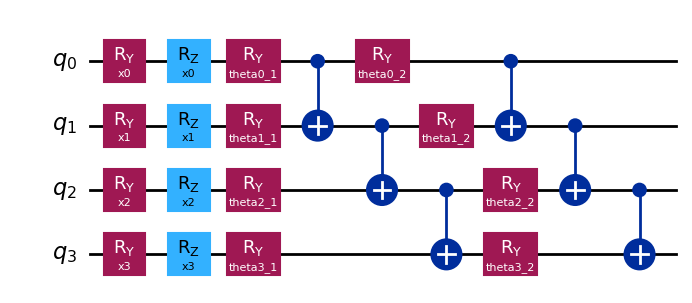

In [33]:
qc.draw(output='mpl')

## 🏗️ Quantum Model Construction  
In this section, we define the quantum neural network (QNN) using Qiskit’s Estimator-based workflow.  
The circuit defined earlier is wrapped in an `EstimatorQNN`, which allows gradient-based optimization through the parameter-shift rule. Finally, we connect it to PyTorch using the `TorchConnector` so it can train alongside classical layers in a hybrid model.

In [42]:
def build_qnn(qc, x_params, theta_params, observables):
    backend = AerSimulator(method='statevector')  # Quantum simulator backend
    estimator = EstimatorV2(mode=backend)         # Evaluates circuit expectation values

    # Gradient computation using the parameter-shift rule
    # For each trainable parameter, the circuit is evaluated twice:
    # once with the parameter shifted +pi/2, once with -pi/2, then the difference gives the gradient
    gradient = ParamShiftEstimatorGradient(estimator)

    qnn = EstimatorQNN(
        circuit=qc,
        estimator=estimator,
        input_params=x_params,
        weight_params=theta_params,
        observables=observables,
        gradient=gradient
    )

    qnn_torch = TorchConnector(qnn)  # Link the QNN with PyTorch for hybrid training
    return qnn, qnn_torch

qnn, qnn_torch = build_qnn(qc, x_params, theta_params, observables)

## 🧬 Hybrid Quantum-Classical Model  

Define a hybrid neural network combining quantum and classical layers:  
- **Quantum layer (`qlayer`)**: outputs expectation values from the QNN circuit.  
- **Classical hidden layer (`hidden`)**: maps quantum outputs to a higher-dimensional space with ReLU activation.  
- **Output layer (`fc`)**: maps to 3 classes for Iris species.  

The model is trained using cross-entropy loss and the Adam optimizer.

In [48]:
class HybridModel(nn.Module):
    def __init__(self, qlayer):
        super().__init__()
        # Quantum layer: outputs expectation values from the quantum circuit
        self.qlayer = qlayer
        
        # Classical hidden layer: maps quantum outputs to a higher-dimensional space
        self.hidden = nn.Linear(QUBIT_COUNT, 6)  # 6 neurons in hidden layer
        
        # Non-linear activation function
        self.relu = nn.ReLU()
        
        # Output layer: maps hidden layer to 3 classes (Iris species)
        self.fc = nn.Linear(6, 3)  # 3 output neurons, one per class
    
    def forward(self, x):
        # Pass input through quantum layer
        x = self.qlayer(x)
        
        # Pass quantum output through classical hidden layer + activation
        x = self.hidden(x)
        x = self.relu(x)
        
        # Final linear layer to get logits for each class
        x = self.fc(x)
        return x
    
model = HybridModel(qlayer=qnn_torch)     # Create an instance of the hybrid model
criterion = nn.CrossEntropyLoss()         # Cross-entropy loss for multi-class classification

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Adam optimizer

In [36]:
train_losses = []
train_accuracies = []

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()                  # Reset gradients
        outputs = model(batch_x)               # Forward pass
        loss = criterion(outputs, batch_y)     # Compute batch loss
        loss.backward()                        # Backpropagate
        optimizer.step()                       # Update parameters
        
        epoch_loss += loss.item() * batch_x.size(0)  # Sum loss weighted by batch size
        _, preds = torch.max(outputs, 1)
        correct += (preds == batch_y).sum().item()
        total += batch_x.size(0)
    
    # Average metrics over epoch
    epoch_loss /= total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    if not LOG_INTERVAL == None and (epoch + 1) % LOG_INTERVAL == 0:
        print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Train Accuracy={epoch_acc:.4f}")

KeyboardInterrupt: 

In [ ]:
if USE_RICHER_ENCODING:
    model_path = RICH_ENCODING_MODEL_PATH
    metrics_path = RICH_ENCODING_METRICS_PATH
else:
    model_path = PLAIN_ENCODING_MODEL_PATH
    metrics_path = PLAIN_ENCODING_METRICS_PATH

torch.save(model.state_dict(), model_path)
np.save(metrics_path, [train_losses, train_accuracies])

In [49]:
def load_hybrid_model(richer_encoding: bool, saved_model_path: str):
    global USE_RICHER_ENCODING
    original_flag = USE_RICHER_ENCODING
    USE_RICHER_ENCODING = richer_encoding

    # Build quantum circuit
    qc, x_params, theta_params, observables = build_quantum_circuit(use_richer_encoding=USE_RICHER_ENCODING)

    # Build QNN and Torch connector
    qnn, qnn_torch = build_qnn(qc, x_params, theta_params, observables)

    # Create model and attach the quantum layer
    model = HybridModel(qnn_torch)

    # Load saved weights
    model.load_state_dict(torch.load(saved_model_path))
    model.eval()

    # Restore the original flag
    USE_RICHER_ENCODING = original_flag
    return model

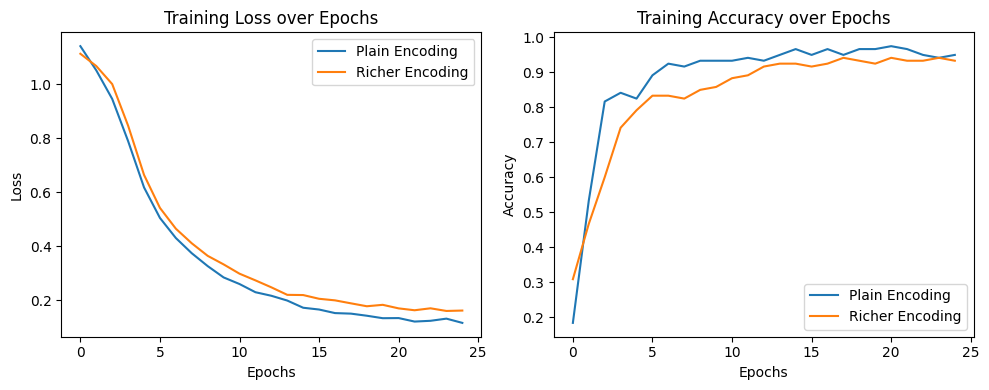

Plain Encoding - Test Accuracy: 1.0000
Richer Encoding - Test Accuracy: 1.0000


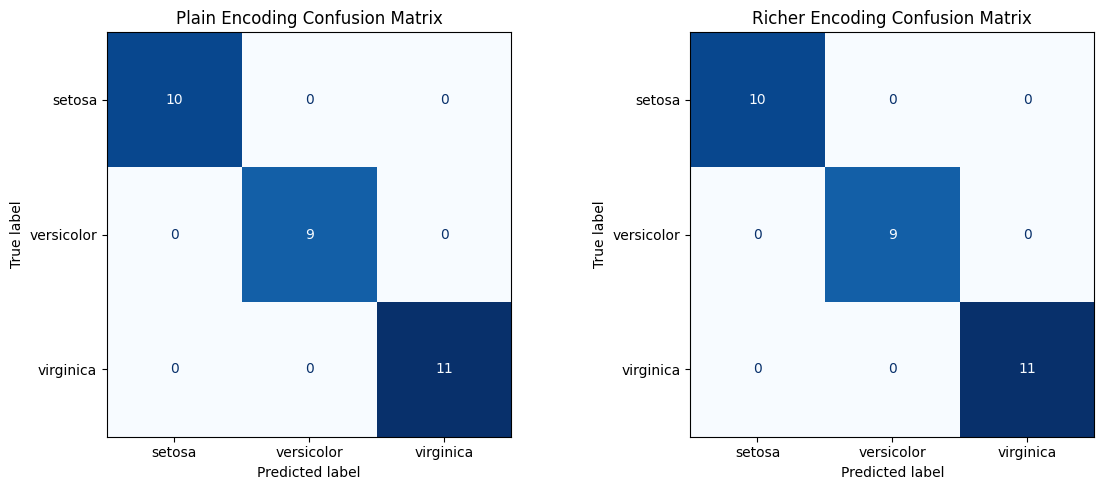


Plain Encoding Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Richer Encoding Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      1.00      0.95         9
   virginica       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



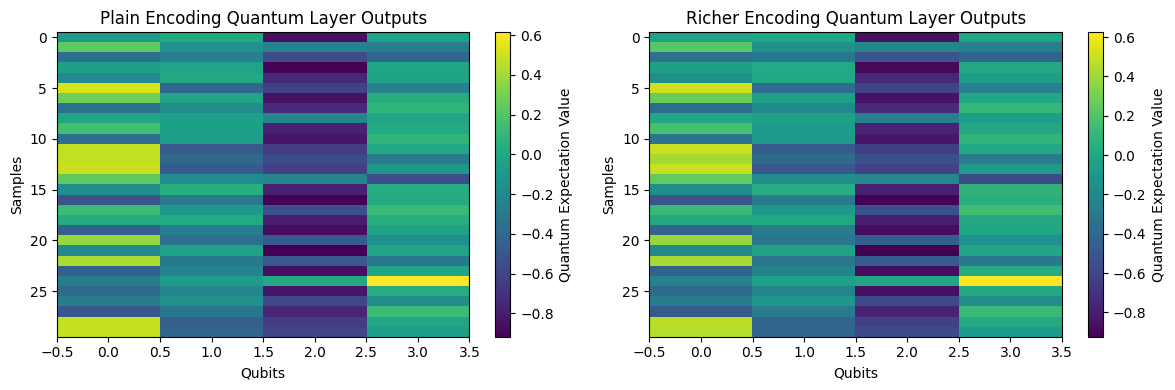

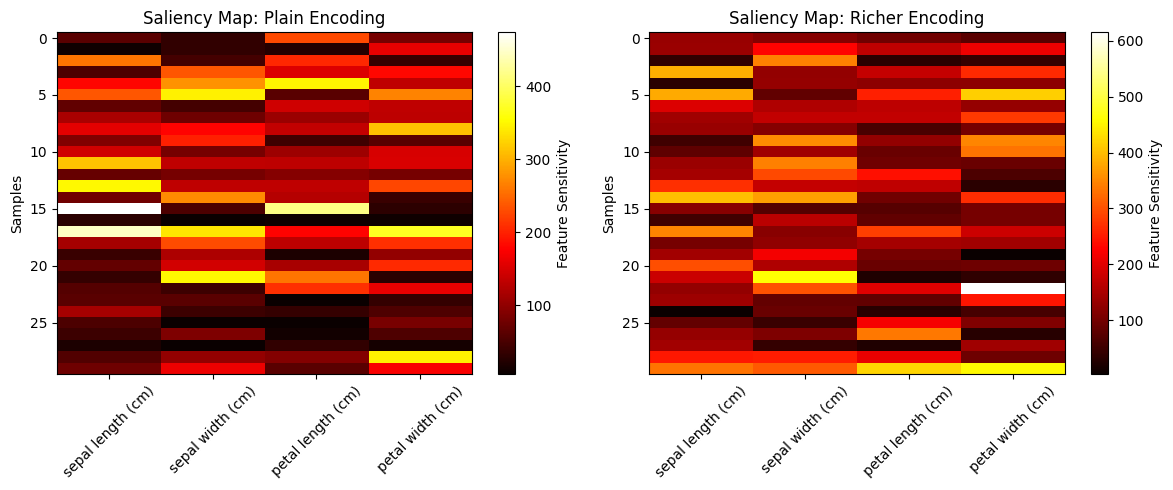

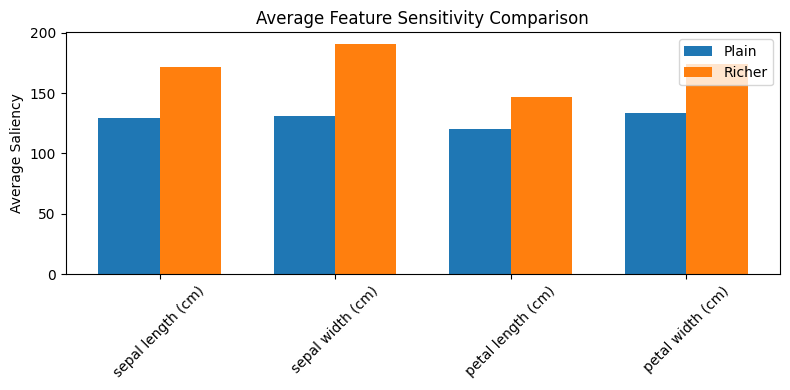

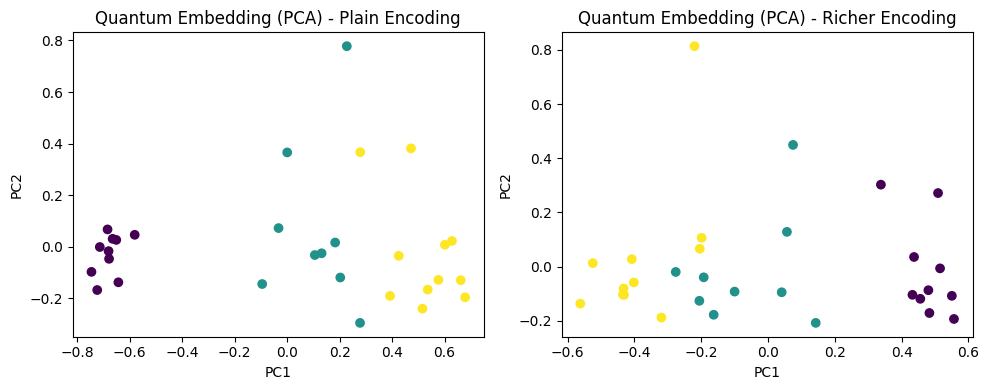

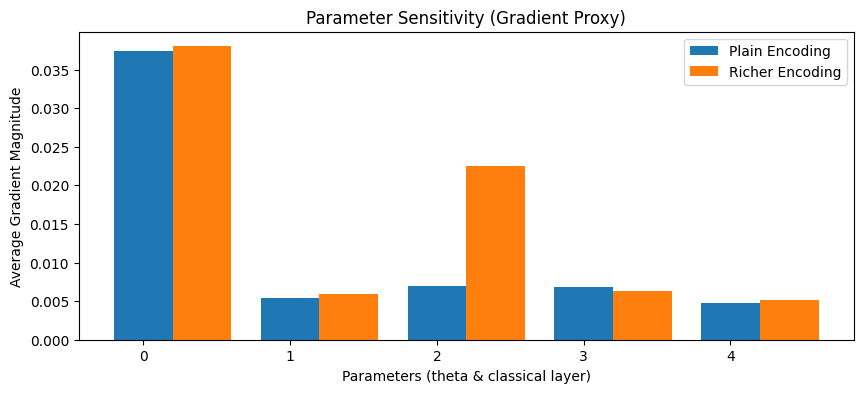

Wilcoxon Test: Plain vs Richer Encoding Feature Saliency

sepal length (cm): stat=159.0000, p=0.1347 
sepal width (cm): stat=117.0000, p=0.0164 *
petal length (cm): stat=176.0000, p=0.2534 
petal width (cm): stat=175.0000, p=0.2449 


In [56]:
model_plain = load_hybrid_model(False, PLAIN_ENCODING_MODEL_PATH)
model_rich = load_hybrid_model(True, RICH_ENCODING_MODEL_PATH)

models = {"Plain Encoding": model_plain, "Richer Encoding": model_rich}

plain_losses, plain_acc = np.load(PLAIN_ENCODING_METRICS_PATH + ".npy", allow_pickle=True)
rich_losses, rich_acc = np.load(RICH_ENCODING_METRICS_PATH + ".npy", allow_pickle=True)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(plain_losses, label="Plain Encoding")
plt.plot(rich_losses, label="Richer Encoding")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(plain_acc, label="Plain Encoding")
plt.plot(rich_acc, label="Richer Encoding")
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()

# ----- 1. Test set evaluation & confusion matrices -----
plt.figure(figsize=(12,5))
for i, (name, mdl) in enumerate(models.items()):
    with torch.no_grad():
        outputs = mdl(X_test)
        _, preds = torch.max(outputs, 1)
        test_acc = (preds == y_test).float().mean().item()
        print(f"{name} - Test Accuracy: {test_acc:.4f}")

        # Confusion matrix
        cm = confusion_matrix(y_test.numpy(), preds.numpy())
        plt.subplot(1, 2, i+1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
        disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
        plt.title(f"{name} Confusion Matrix")
plt.tight_layout()
plt.show()

for name, mdl in models.items():
    with torch.no_grad():
        outputs = mdl(X_test)
        _, preds = torch.max(outputs, 1)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, preds, target_names=iris.target_names))

# ----- 2. Quantum layer outputs side-by-side -----
plt.figure(figsize=(12,4))
for i, (name, mdl) in enumerate(models.items()):
    q_outputs = qnn_torch(X_test).detach().numpy()  # Assuming qnn_torch is same for both
    plt.subplot(1,2,i+1)
    plt.imshow(q_outputs, cmap='viridis', aspect='auto')
    plt.colorbar(label="Quantum Expectation Value")
    plt.title(f"{name} Quantum Layer Outputs")
    plt.xlabel("Qubits")
    plt.ylabel("Samples")
plt.tight_layout()
plt.show()

# ----- 3. Saliency maps side-by-side -----
def compute_saliency(model, inputs, delta=1e-3):
    model.eval()
    inputs = inputs.clone().detach()
    base_output = model(inputs).detach().numpy()
    saliency = np.zeros_like(inputs)

    for feature_idx in range(inputs.shape[1]):
        perturbed = inputs.clone()
        perturbed[:, feature_idx] += delta
        perturbed_output = model(perturbed).detach().numpy()
        grad_estimate = (perturbed_output - base_output) / delta
        saliency[:, feature_idx] = np.mean(np.abs(grad_estimate), axis=1)
    return saliency

saliency_plain = compute_saliency(model_plain, X_test)
saliency_rich = compute_saliency(model_rich, X_test)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(saliency_plain, cmap='hot', aspect='auto')
plt.colorbar(label="Feature Sensitivity")
plt.title("Saliency Map: Plain Encoding")
plt.xticks(range(X_test.shape[1]), iris.feature_names, rotation=45)
plt.ylabel("Samples")

plt.subplot(1,2,2)
plt.imshow(saliency_rich, cmap='hot', aspect='auto')
plt.colorbar(label="Feature Sensitivity")
plt.title("Saliency Map: Richer Encoding")
plt.xticks(range(X_test.shape[1]), iris.feature_names, rotation=45)
plt.ylabel("Samples")
plt.tight_layout()
plt.show()

mean_plain = saliency_plain.mean(axis=0)
mean_rich = saliency_rich.mean(axis=0)

plt.figure(figsize=(8,4))
x = np.arange(len(iris.feature_names))
width = 0.35
plt.bar(x - width/2, mean_plain, width, label="Plain")
plt.bar(x + width/2, mean_rich, width, label="Richer")
plt.xticks(x, iris.feature_names, rotation=45)
plt.ylabel("Average Saliency")
plt.title("Average Feature Sensitivity Comparison")
plt.legend()
plt.tight_layout()
plt.show()

def visualize_latent(model, name):
    with torch.no_grad():
        latent = model.qlayer(X_test).detach().numpy()
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent)
    plt.scatter(latent_2d[:,0], latent_2d[:,1], c=y_test, cmap='viridis')
    plt.title(f"Quantum Embedding (PCA) - {name}")
    plt.xlabel("PC1"); plt.ylabel("PC2")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); visualize_latent(model_plain, "Plain Encoding")
plt.subplot(1,2,2); visualize_latent(model_rich, "Richer Encoding")
plt.tight_layout()
plt.show()

# ----- 4. Interpretability hooks: parameter sensitivity -----
plt.figure(figsize=(10,4))

for i, (name, mdl) in enumerate(models.items()):
    # Ensure model is in training mode so gradients can be computed
    mdl.train()
    
    # Zero previous gradients
    optimizer = torch.optim.Adam(mdl.parameters())  # Temporary optimizer for backward
    optimizer.zero_grad()
    
    # Forward pass
    outputs = mdl(X_test)
    loss = criterion(outputs, y_test)
    
    # Backward pass
    loss.backward()
    
    # Collect average gradient magnitudes
    grads = []
    for param in mdl.parameters():
        if param.requires_grad and param.grad is not None:
            grads.append(param.grad.detach().abs().mean().item())
    
    # Plot the gradients
    plt.bar(np.arange(len(grads)) + i*0.4, grads, width=0.4, label=name)

plt.xlabel("Parameters (theta & classical layer)")
plt.ylabel("Average Gradient Magnitude")
plt.title("Parameter Sensitivity (Gradient Proxy)")
plt.legend()
plt.show()


# ----- 5. Wilcoxon test on feature saliency -----
print("Wilcoxon Test: Plain vs Richer Encoding Feature Saliency\n")
for feature_idx, feature_name in enumerate(iris.feature_names):
    # Extract saliency values for this feature
    plain_vals = saliency_plain[:, feature_idx]
    rich_vals = saliency_rich[:, feature_idx]
    
    # Perform Wilcoxon signed-rank test
    stat, p = wilcoxon(plain_vals, rich_vals)
    
    # Mark significance
    sig = ""
    if p < 0.05:
        sig = "*"  # Statistically significant
    print(f"{feature_name:15}: stat={stat:.4f}, p={p:.4f} {sig}")